<!-- PS-S4.E10 | EDA - Langchain - AutoGluon -->
<a id="0"></a>
<div style="font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#FF6B6B; font-size:300%; text-align:left; padding:3.0px; background: #2B303A; border-bottom: 8px solid #36454F">
    PS-S4.E10 | EDA - Langchain - AutoGluon<br>
</div>

<img src="https://i.imgur.com/CWjMMGU.png" width="700px">

In [1]:
!pip install autogluon.tabular  > /dev/null 2>&1
!pip install sweetviz > /dev/null 2>&1
!pip install optuna-integration[sklearn] > /dev/null 2>&1
!pip install langchain-core > /dev/null 2>&1
!pip install langchain-openai  > /dev/null 2>&1

In [2]:
# Import libraries

import tempfile

# LLM
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
import json

# General Purpose Libraries
import logging
import numpy as np
import pandas as pd
import sweetviz as sv
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product

# Feature engineering
from sklearn.preprocessing import KBinsDiscretizer
from featuretools import dfs, EntitySet

from autogluon.tabular import TabularPredictor

In [3]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
OPENAI_API_KEY = user_secrets.get_secret("openai_key")

In [4]:
# maxium training time in sec
TIME_LIMIT = 3600 * 5

In [5]:
# Load the dataset
train_data = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')

<!-- Simple EDA -->
<h1 id="2" style="font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#FF6B6B; font-size:200%; text-align:left; padding:3.0px; background: #2B303A; border-bottom: 8px solid #36454F;">
    Simple EDA
</h1>

In [6]:
# Function to classify columns into continuous and categorical
def classify_columns(df):
    continuous_cols = []
    categorical_cols = []
    for column in df.columns:
        if df[column].dtypes == 'object':
            categorical_cols.append(column)
        else:
            unique_values = df[column].nunique()
            if unique_values < 15:
                categorical_cols.append(column)
            else:
                continuous_cols.append(column)
    return continuous_cols, categorical_cols

# Function to perform basic visualizations for continuous and categorical features
def eda_visualizations(df, target=None):
    continuous_cols, categorical_cols = classify_columns(df)
    
    # Plotting continuous columns
    for col in continuous_cols:
        plt.figure(figsize=(10, 4))
        sns.histplot(df[col], kde=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()
    
    # Plotting categorical columns
    for col in categorical_cols:
        plt.figure(figsize=(10, 4))
        sns.countplot(data=df, x=col, hue=target)
        plt.title(f'Count plot for {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()

# Function to compare train and test datasets
def compare_train_test(train, test):
    continuous_cols, categorical_cols = classify_columns(train)
    
    # Compare continuous columns
    for col in continuous_cols:
        plt.figure(figsize=(10, 4))
        sns.kdeplot(train[col], label='Train', shade=True)
        sns.kdeplot(test[col], label='Test', shade=True)
        plt.title(f'Comparison of {col} Distribution in Train vs Test')
        plt.xlabel(col)
        plt.ylabel('Density')
        plt.legend()
        plt.show()
    
    # Compare categorical columns
    for col in categorical_cols:
        if col in test.columns:  # Ensure the column exists in the test dataset
            plt.figure(figsize=(10, 4))
            train_counts = train[col].value_counts(normalize=True)
            test_counts = test[col].value_counts(normalize=True)
            train_counts.plot(kind='bar', alpha=0.5, label='Train', color='blue')
            test_counts.plot(kind='bar', alpha=0.5, label='Test', color='red')
            plt.title(f'Comparison of {col} Proportions in Train vs Test')
            plt.xlabel(col)
            plt.ylabel('Proportion')
            plt.legend()
            plt.xticks(rotation=45)
            plt.show()
            
# Function to create key statistics for a dataset
def eda_summary(df):
    summary = {}
    
    # General Info
    summary['general'] = {
        'num_rows': df.shape[0],
        'num_columns': df.shape[1],
        'num_missing_values': df.isnull().sum().sum(),
        'percent_missing_values': df.isnull().mean().mean() * 100
    }
    
    # Column Data Types
    summary['data_types'] = df.dtypes.to_dict()
    
    # Missing Value Summary (per column)
    summary['missing_values'] = (
        df.isnull()
        .sum()
        .to_frame(name='missing_count')
        .assign(percent_missing=lambda x: (x['missing_count'] / df.shape[0]) * 100)
        .to_dict(orient='index')
    )
    
    # Numerical Summary (Mean, Median, Std, Min, Max)
    describe_df = df.describe()
    numerical_columns = ['mean', '50%', 'std', 'min', 'max']
    available_columns = [col for col in numerical_columns if col in describe_df.columns]
    summary['numerical_summary'] = (
        describe_df[available_columns]
        .rename(columns={'50%': 'median'})
        .to_dict(orient='index')
    )
    
    # Unique Counts for Categorical Columns
    summary['categorical_summary'] = (
        df.select_dtypes(include=['object', 'category'])
        .nunique()
        .to_frame(name='unique_counts')
        .to_dict(orient='index')
    )
    
    # Skewness and Kurtosis
    summary['skewness_kurtosis'] = {
        column: {
            'skewness': df[column].skew(),
            'kurtosis': df[column].kurt()
        } for column in df.select_dtypes(include=[np.number]).columns
    }
    
    # Correlations
    try:
        summary['correlations'] = df.corr(numeric_only=True).to_dict()
    except ValueError:
        summary['correlations'] = "Unable to calculate correlations due to data type issues."
    
    # Outlier Count based on IQR
    outlier_summary = {}
    for column in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))]
        outlier_summary[column] = {
            'outlier_count': outliers.shape[0],
            'percent_outliers': (outliers.shape[0] / df.shape[0]) * 100
        }
    summary['outlier_summary'] = outlier_summary

    return summary

In [7]:
# Basic Exploration
train_data.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [8]:
test_data.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


In [9]:
sample_submission.head()

,id,loan_status
0,58645,0.5
1,58646,0.5
2,58647,0.5
3,58648,0.5
4,58649,0.5


In [10]:
train_data.shape

(58645, 13)

In [11]:
test_data.shape

(39098, 12)

In [12]:
train_data.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,29322.000000,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,16929.497605,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,0.000000,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,14661.000000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,29322.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,43983.000000,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,58644.000000,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [13]:
test_data.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
count,39098.000000,39098.000000,3.909800e+04,39098.000000,39098.000000,39098.000000,39098.000000,39098.000000
mean,78193.500000,27.566781,6.406046e+04,4.687068,9251.466188,10.661216,0.159573,5.830707
std,11286.764749,6.032761,3.795583e+04,3.868395,5576.254680,3.020220,0.091633,4.072157
min,58645.000000,20.000000,4.000000e+03,0.000000,700.000000,5.420000,0.000000,2.000000
25%,68419.250000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000
50%,78193.500000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000
75%,87967.750000,30.000000,7.588500e+04,7.000000,12000.000000,12.990000,0.210000,8.000000
max,97742.000000,94.000000,1.900000e+06,42.000000,35000.000000,22.110000,0.730000,30.000000


In [14]:
# Automated EDA report with sweetviz

# Comparing the train and test datasets
report = sv.compare([train_data, "Train"], [test_data, "Test"])
report.show_html(filepath='/kaggle/working/Comparative_EDA_Report.html', open_browser=False)

                                             |          | [  0%]   00:00 -> (? left)

Report /kaggle/working/Comparative_EDA_Report.html was generated.


*  EDA in Output/Comparative_EDA_Report.html

In [15]:
summary = eda_summary(train_data)

# Convert summary to JSON format
summary_json = json.dumps(summary, indent=4, default=str)

In [16]:
# Define the prompt template for LangChain
template_eda = """Provide an analysis of the following EDA summary:
{context}

Key insights and observations:
"""

prompt = ChatPromptTemplate.from_template(template_eda)

# Define the LLM model using LangChain
model = ChatOpenAI(
    model='gpt-4o-2024-05-13',
    temperature=0,
    api_key=OPENAI_API_KEY
)

# Create a chain to pass the summary to the model
chain = prompt | model | StrOutputParser()

# Invoke the chain to analyze the EDA summary
result = chain.invoke(summary_json)

# Print the result
print(result)

The provided EDA (Exploratory Data Analysis) summary offers a comprehensive overview of the dataset, including general information, data types, missing values, numerical and categorical summaries, skewness and kurtosis, correlations, and outlier analysis. Here are the key insights and observations:

### General Information
- **Number of Rows:** 58,645
- **Number of Columns:** 13
- **Missing Values:** None (0 missing values, 0.0% missing)

### Data Types
- **Numerical Columns:** `id`, `person_age`, `person_income`, `person_emp_length`, `loan_amnt`, `loan_int_rate`, `loan_percent_income`, `cb_person_cred_hist_length`, `loan_status`
- **Categorical Columns:** `person_home_ownership`, `loan_intent`, `loan_grade`, `cb_person_default_on_file`

### Missing Values
- There are no missing values in any of the columns, which is excellent for analysis as it eliminates the need for imputation or data cleaning related to missing values.

### Numerical Summary
- The numerical summary section is empty

In [17]:
# Define the prompt template for LangChain
template_features = """Provide an analysis of the following EDA summary and offer advice on feature engineering to improve predictions of loan approvals:
{context}

Feature Engineering Recommendations:
"""

prompt = ChatPromptTemplate.from_template(template_features)
chain = prompt | model | StrOutputParser()
result = chain.invoke(summary_json)
print(result)

Based on the provided Exploratory Data Analysis (EDA) summary, here are some feature engineering recommendations to improve the predictions of loan approvals:

### 1. Handling Skewness and Outliers
- **Skewness**: Several features exhibit high skewness, such as `person_age`, `person_income`, `person_emp_length`, and `loan_amnt`. Applying transformations like log, square root, or Box-Cox transformations can help normalize these distributions.
- **Outliers**: Features like `person_age`, `person_income`, `person_emp_length`, `loan_amnt`, and `loan_status` have a significant number of outliers. Consider using techniques like IQR-based filtering, winsorization, or robust scaling to mitigate the impact of outliers.

### 2. Feature Interactions
- **Loan Amount and Income**: Create interaction features such as `loan_amnt_to_income_ratio` (loan amount divided by income) to capture the relationship between the loan amount and the applicant's income.
- **Employment Length and Age**: Create a feat

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


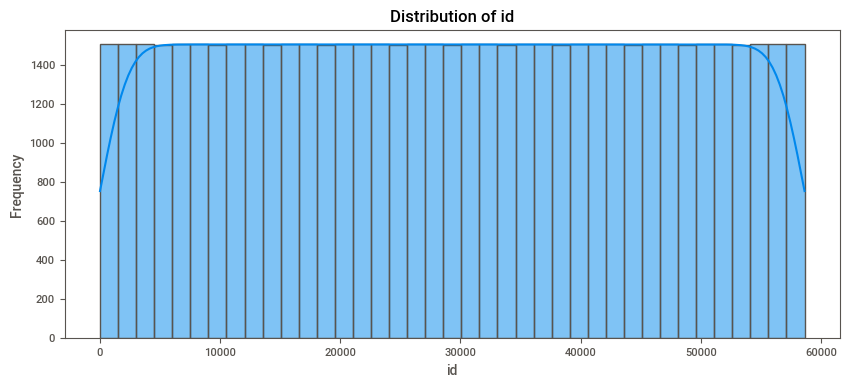

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


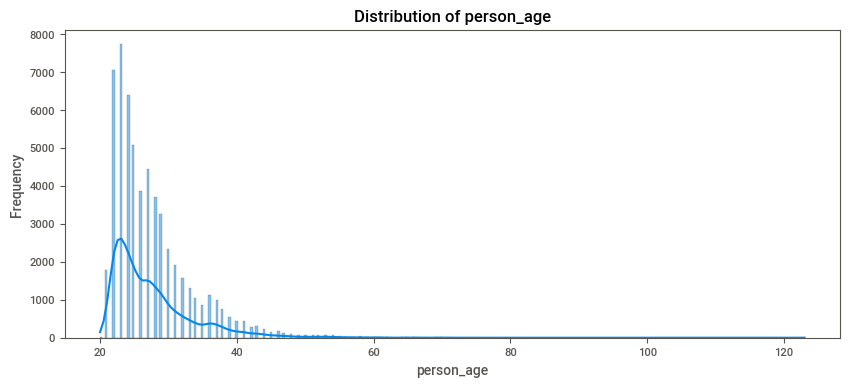

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


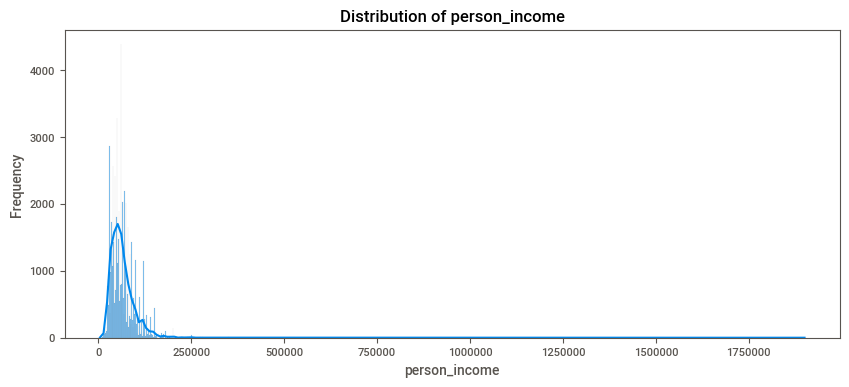

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


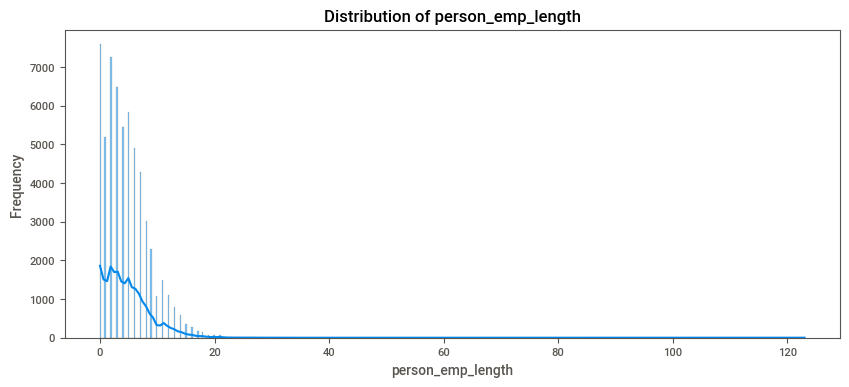

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


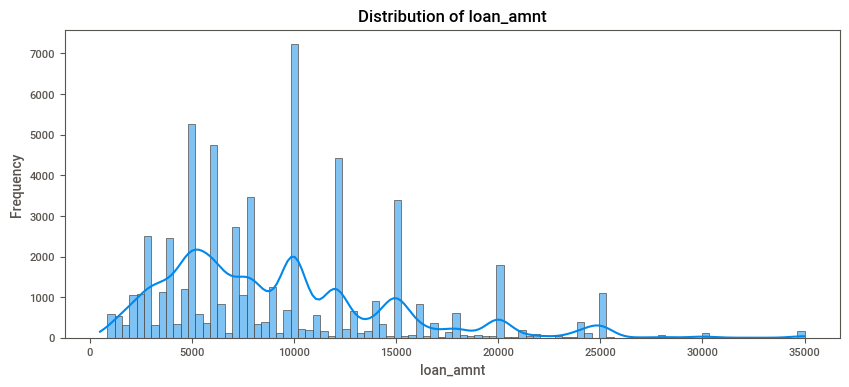

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


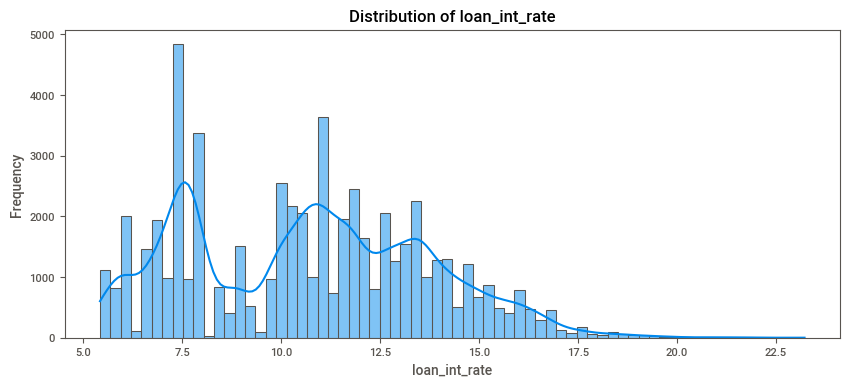

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


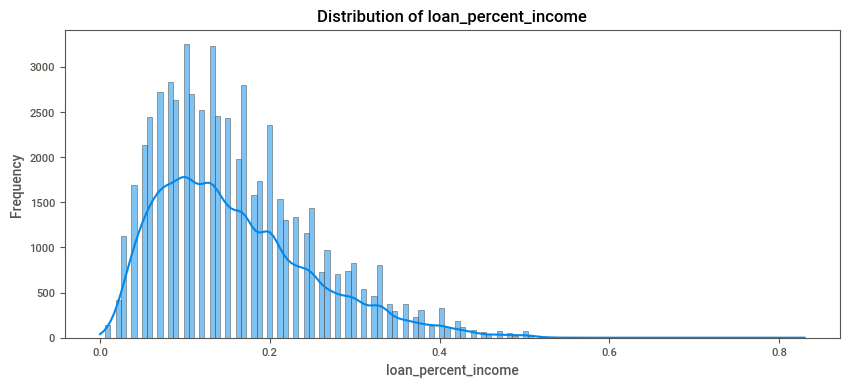

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


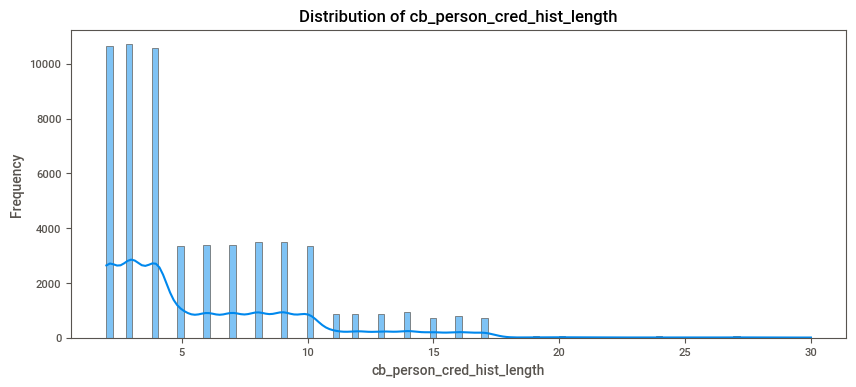

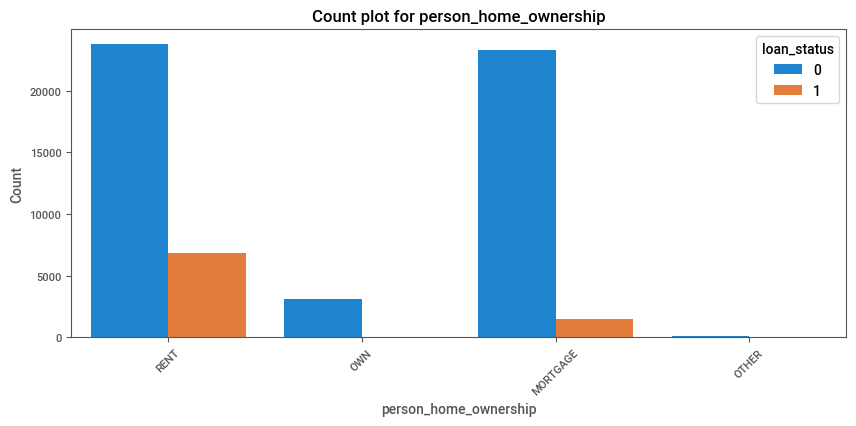

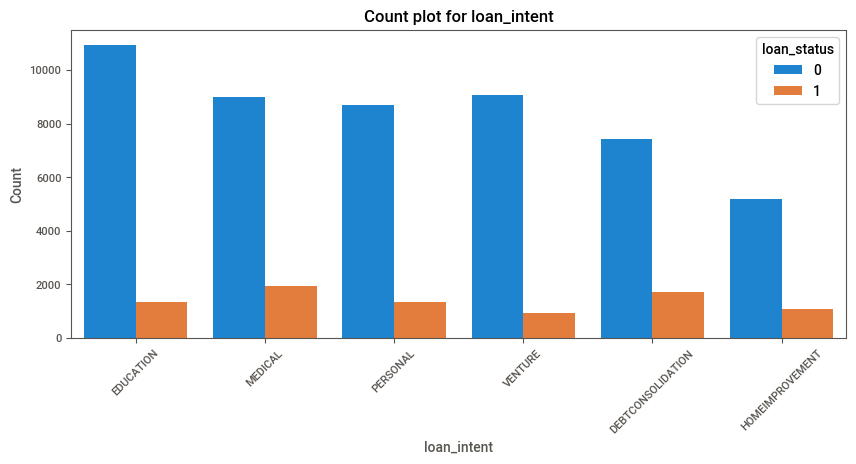

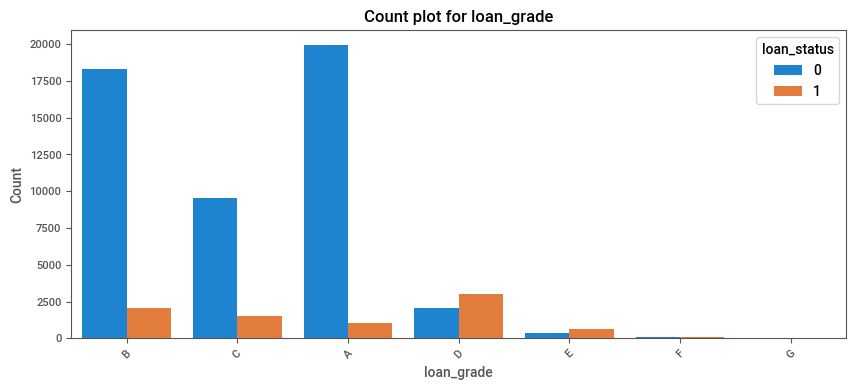

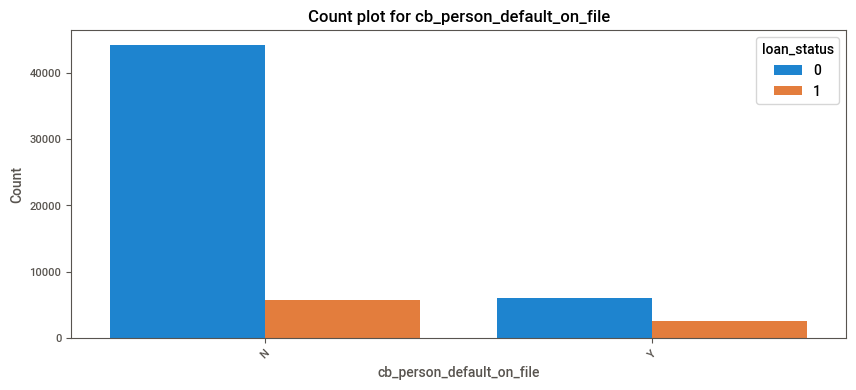

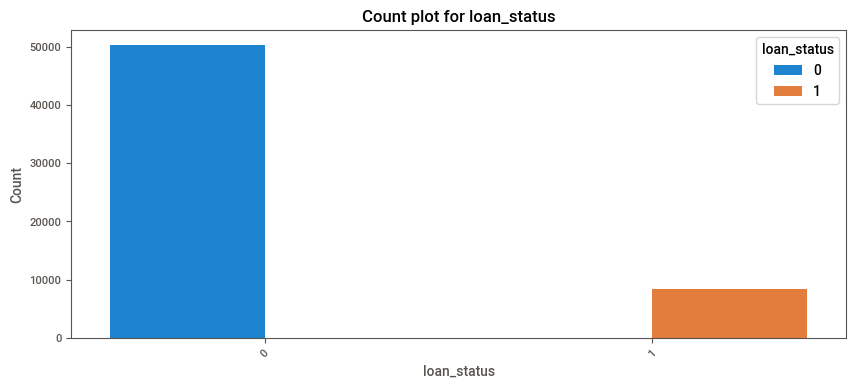

In [18]:
# Automated EDA
eda_visualizations(train_data, target='loan_status')

/tmp/ipykernel_23/3449574009.py:46: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train[col], label='Train', shade=True)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_23/3449574009.py:47: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test[col], label='Test', shade=True)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_a

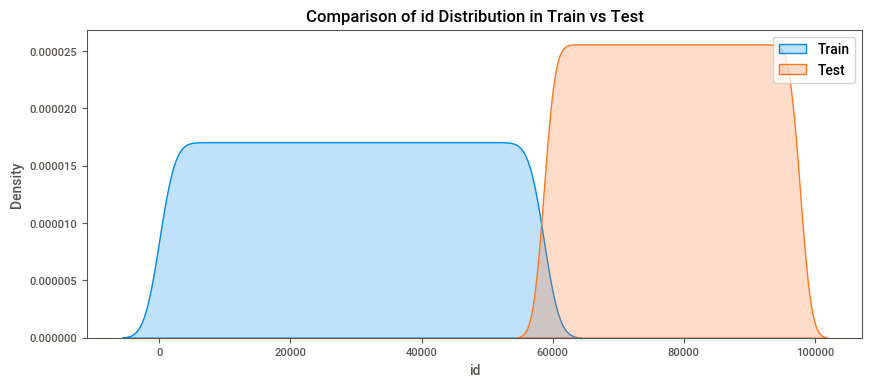

/tmp/ipykernel_23/3449574009.py:46: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train[col], label='Train', shade=True)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_23/3449574009.py:47: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test[col], label='Test', shade=True)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_a

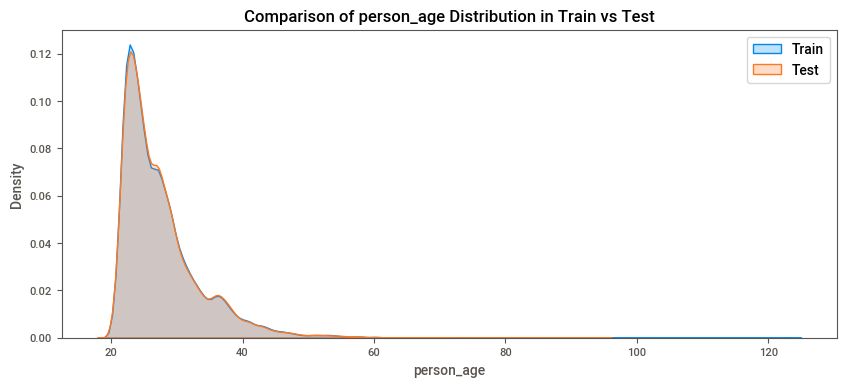

/tmp/ipykernel_23/3449574009.py:46: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train[col], label='Train', shade=True)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_23/3449574009.py:47: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test[col], label='Test', shade=True)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_a

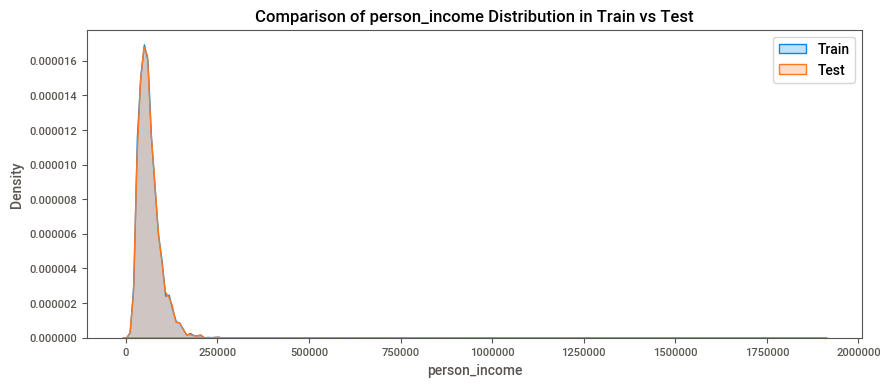

/tmp/ipykernel_23/3449574009.py:46: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train[col], label='Train', shade=True)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_23/3449574009.py:47: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test[col], label='Test', shade=True)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_a

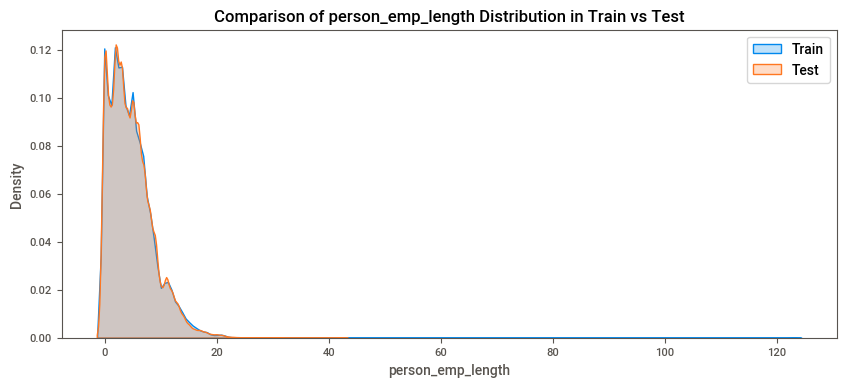

/tmp/ipykernel_23/3449574009.py:46: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train[col], label='Train', shade=True)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_23/3449574009.py:47: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test[col], label='Test', shade=True)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_a

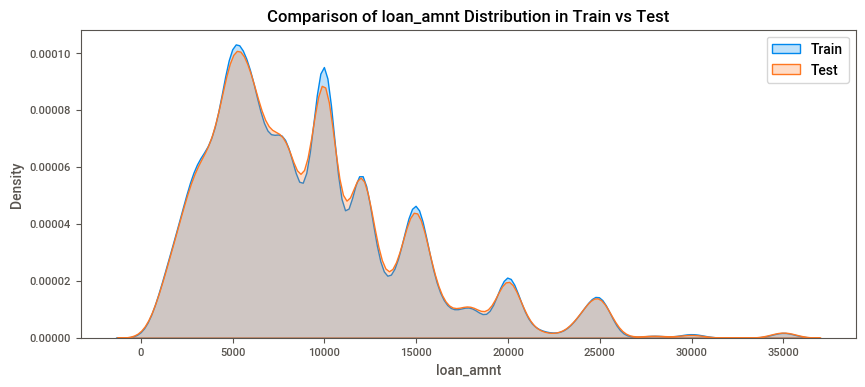

/tmp/ipykernel_23/3449574009.py:46: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train[col], label='Train', shade=True)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_23/3449574009.py:47: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test[col], label='Test', shade=True)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_a

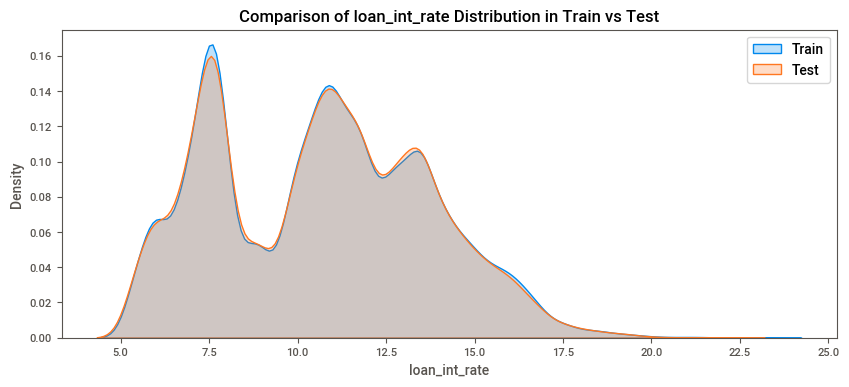

/tmp/ipykernel_23/3449574009.py:46: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train[col], label='Train', shade=True)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_23/3449574009.py:47: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test[col], label='Test', shade=True)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_a

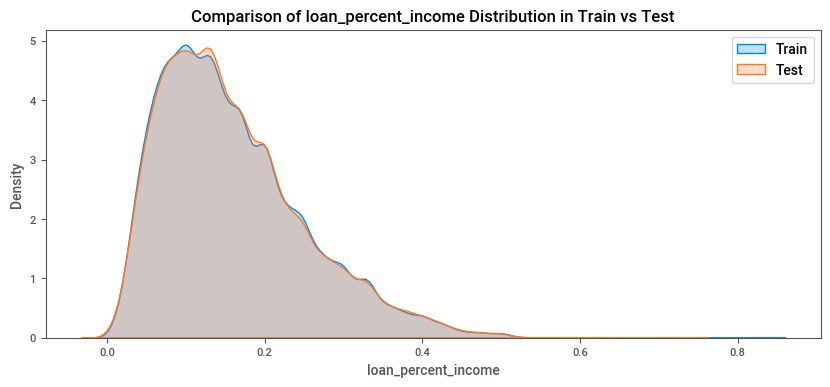

/tmp/ipykernel_23/3449574009.py:46: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train[col], label='Train', shade=True)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_23/3449574009.py:47: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test[col], label='Test', shade=True)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_a

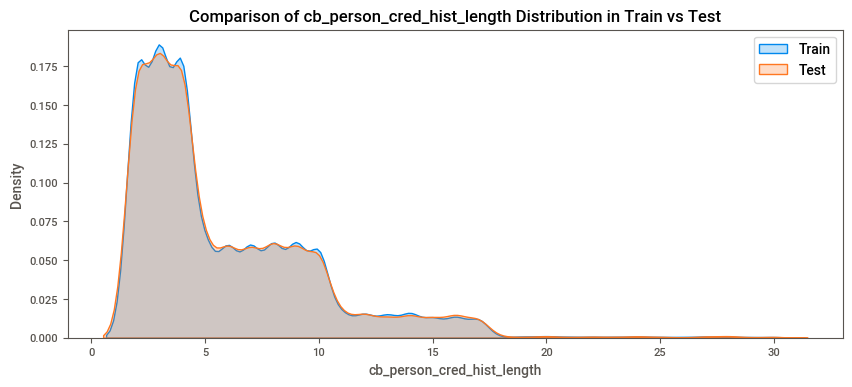

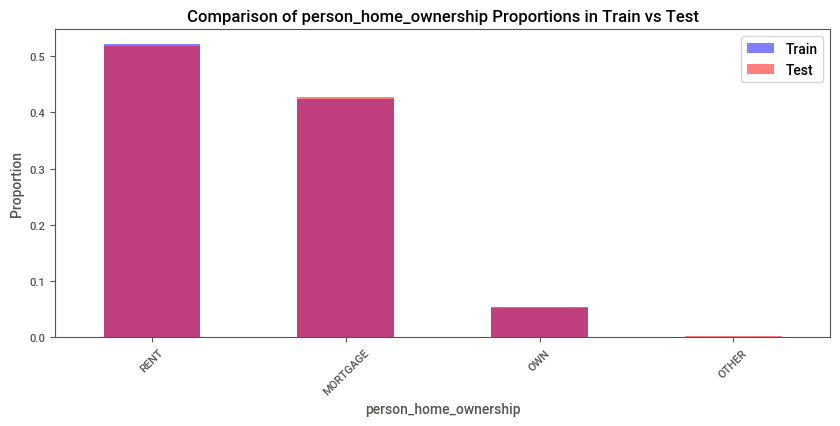

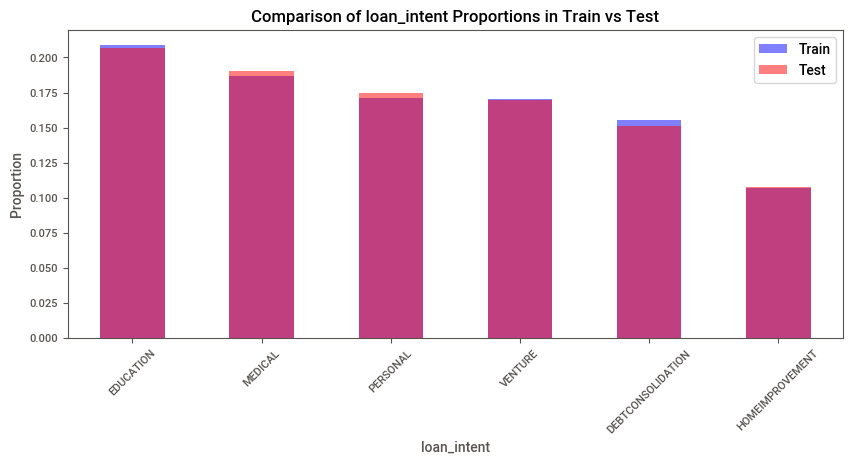

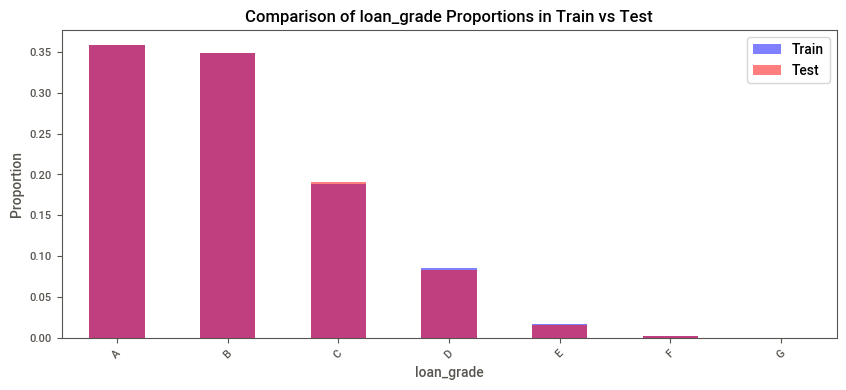

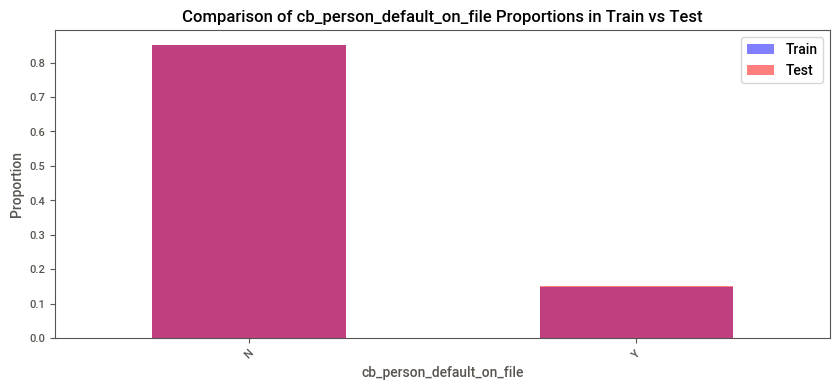

In [19]:
# Comparing train and test datasets
compare_train_test(train_data, test_data)

<a id="2"></a>
<div style="font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#FF6B6B; font-size:200%; text-align:left; padding:3.0px; background: #2B303A; border-bottom: 8px solid #36454F">
    Feature engineering<br>
</div>

In [20]:
# Function for enhanced feature engineering optimized for tree-based models
def feature_engineering(df):
    # Handle skewness using power transformation for highly skewed variables
    skewed_features = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt']
    for feature in skewed_features:
        if df[feature].skew() > 1:
            df[f'{feature}_boxcox'] = np.log1p(df[feature])  # Apply log transformation to reduce skewness

    # Optionally retain original skewed features and remove later if necessary
    # Cap outliers using the IQR method to reduce their influence
    for feature in skewed_features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[feature] = np.where(df[feature] < lower_bound, lower_bound, df[feature])
        df[feature] = np.where(df[feature] > upper_bound, upper_bound, df[feature])

    # Creating interaction features
    df['loan_amnt_to_income_ratio'] = df['loan_amnt'] / (df['person_income'] + 1e-5)
    df['emp_length_to_age_ratio'] = df['person_emp_length'] / (df['person_age'] + 1e-5)
    df['cred_hist_length_to_age_ratio'] = df['cb_person_cred_hist_length'] / (df['person_age'] + 1e-5)
    df['loan_int_rate_to_income'] = df['loan_int_rate'] / (df['person_income'] + 1e-5)

    # Automated binning using KBinsDiscretizer
    discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
    df['income_binned'] = discretizer.fit_transform(df[['person_income']])
    df['age_binned'] = discretizer.fit_transform(df[['person_age']])

    # One-hot encoding for categorical features
    categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
    # Check if categorical features exist in the dataframe
    available_features = [feature for feature in categorical_features if feature in df.columns]
    df = pd.get_dummies(df, columns=available_features, drop_first=True)

    # Adding statistical group features (e.g., mean, sum) per categorical group
    if 'person_home_ownership' in df.columns and 'person_income' in df.columns:
        df['mean_income_by_home_ownership'] = df.groupby('person_home_ownership')['person_income'].transform('mean')
    if 'loan_intent' in df.columns and 'loan_amnt' in df.columns:
        df['sum_loan_amnt_by_intent'] = df.groupby('loan_intent')['loan_amnt'].transform('sum')
    if 'loan_intent' in df.columns and 'person_emp_length' in df.columns:
        df['median_emp_length_by_intent'] = df.groupby('loan_intent')['person_emp_length'].transform('median')

    # Feature generation with FeatureTools for automated feature extraction
    es = EntitySet(id="loan_data")
    es.add_dataframe(dataframe_name="loans", dataframe=df, index="id")
    feature_matrix, feature_defs = dfs(entityset=es, target_dataframe_name="loans", max_depth=2)

    # Remove duplicate columns from feature_matrix before concatenation
    feature_matrix = feature_matrix.loc[:, ~feature_matrix.columns.isin(df.columns)]

    # Incorporate automated features from FeatureTools
    df = pd.concat([df, feature_matrix], axis=1)

    return df

# Apply feature engineering to train and test datasets
train_data = feature_engineering(train_data)
test_data = feature_engineering(test_data)

/opt/conda/lib/python3.10/site-packages/featuretools/synthesis/deep_feature_synthesis.py:169: UserWarning: Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/featuretools/synthesis/deep_feature_synthesis.py:169: UserWarning: Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created
  warnings.warn(


<!-- Explore best models -->
<h1 id="3" style="font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#FF6B6B; font-size:200%; text-align:left; padding:3.0px; background: #2B303A; border-bottom: 8px solid #36454F;">
    Explore best models
</h1>

In [21]:
# Preparing training data
# Drop 'id' column since it is not useful for training
train_data = train_data.drop(columns=['id'])

# Define target variable
target = 'loan_status'

In [22]:
# Train AutoGluon model

# Create a temporary directory to avoid saving models to a permanent folder
temp_model_path = tempfile.mkdtemp() # saving all the output was causing issues with submission 

# Train AutoGluon model with the desired adjustments
predictor = TabularPredictor(label=target, eval_metric='roc_auc', path=temp_model_path).fit(
    train_data,
    presets='best_quality',  # Using the best quality preset for higher accuracy
    time_limit=TIME_LIMIT,  # You can set a time limit to control how long the training runs (in seconds)
    num_bag_folds=10,  # Enable ensembling by using bagging with 8 folds
    num_stack_levels=2,  # Enable stacking to further improve model performance
    ag_args_fit={'use_gpu': True},  # Set to True to use GPU for model training
    verbosity=0  # Set verbosity level to suppress too much logging output (0: most silent, 4: most detailed)
)

2024-10-11 08:18:12,650	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
/opt/conda/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1242: UserWarning: Failed to use ray for memory safe fits. Falling back to normal fit. Error: ValueError('ray==2.24.0 detected. 2.10.0 <= ray < 2.11.0 is required. You can use pip to install certain version of ray `pip install ray==2.10.0` ')
  stacked_overfitting = self._sub_fit_memory_save_wrapper(
/opt/conda/lib/python3.10/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a fu

In [23]:
# Review the leaderboard of different models trained by AutoGluon
leaderboard = predictor.leaderboard(silent=True)
leaderboard

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.960328,roc_auc,9.182042,1377.661140,0.008764,4.985310,2,True,40
1,CatBoost_r50_BAG_L1,0.959296,roc_auc,0.472649,202.731148,0.472649,202.731148,1,True,33
2,CatBoost_r137_BAG_L1,0.958280,roc_auc,0.109765,638.204336,0.109765,638.204336,1,True,23
3,CatBoost_r9_BAG_L1,0.958154,roc_auc,0.425004,261.219932,0.425004,261.219932,1,True,18
4,LightGBM_r131_BAG_L1,0.957427,roc_auc,4.238215,105.263570,4.238215,105.263570,1,True,16
5,CatBoost_r69_BAG_L1,0.957010,roc_auc,0.086493,370.598000,0.086493,370.598000,1,True,37
6,LightGBM_BAG_L1,0.956989,roc_auc,0.742040,39.602027,0.742040,39.602027,1,True,4
7,LightGBM_r130_BAG_L1,0.956897,roc_auc,0.607517,28.088605,0.607517,28.088605,1,True,31
8,CatBoost_r177_BAG_L1,0.956844,roc_auc,0.068481,204.075176,0.068481,204.075176,1,True,14
9,XGBoost_r89_BAG_L1,0.956589,roc_auc,0.483319,72.402066,0.483319,72.402066,1,True,29


<!-- Prepare final submission -->
<h1 id="4" style="font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#FF6B6B; font-size:200%; text-align:left; padding:3.0px; background: #2B303A; border-bottom: 8px solid #36454F;">
    Prepare final submission
</h1>


In [24]:
# Predicting on the test data
# Drop the 'id' column before making predictions
test_data_prepared = test_data.drop(columns=['id'])

# Use AutoGluon to predict probabilities for 'loan_status'
y_test_pred_proba = predictor.predict_proba(test_data_prepared)[1]  # Get probabilities for the positive class

# Create the submission file
submission = pd.DataFrame({
    'id': test_data['id'],
    'loan_status': y_test_pred_proba
})

# Save the submission file
submission.to_csv('loan_prediction_submission.csv', index=False)
print("Submission file saved as 'loan_prediction_submission.csv'")

Submission file saved as 'loan_prediction_submission.csv'
